In [1]:
#purpose is to produce tables for our measurements and to display them in a neat fashion 
#(like proper motion arrows on an image)
'''
Paths and file needs:
*imglams and spitzer_conversions are excel files, right now I have it so you need to put it as same directory as your code (but could later maybe just give it a path to go to - would be smarter)
*paths to images and data in general
'''
#now the steps
'''
1) read in all the data by noting all the paths to the continuum subtracted hst images
2) loop through all the data, read it in, convert units
(optional) 3) cutout all the data as appropriate
3) grab .reg files for each epoch. load them in and all their properties
4) compute shifts and Avs as well as uncertainties
5) compute speeds and gather them from all relevant scales for our problem
'''

#just to check python version - should be 3.8.13
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.wcs import WCS
import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

#this part is unnecessary...in jupyter...but if you're scripting and want to test blocks of code
#you may want switches, EX:
# switch1 = 'on' #convolving images [needed to put it on for switch 3 at min...need to figure out other solution, eh]
# switch1b = 'on' #regridding...
# switch2 = 'on' #solving equations
# switch3 = 'on' #plotting / graphics of solutions

3.8.13


In [2]:
# #finding the path to every fits images in a directory
def im_name_finder(path, file_type):
    #Using glob (it's a unix command similar to ls)
    #WARNING: using recursive=True...depending how many images you use this could be very slow, it's recommended not to have too many subfolders
    #if needed, some example code is commented towards the latter half of this code that could help make an alternative
    all_names = glob.glob(path, recursive=True)

    #IMPORTANT: Using "fit" here because it is inclusive of both fits and FIT...some files end in "FIT" and need to be included
    #using s.lower() include uppercase names
    im_names = [s for s in all_names if 'fit' in s.lower()]

    return im_names


#a new fits file to be saved and viewed in DS9
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''

    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

In [3]:
#reading in some data
path = '../scaling_for_motions/160_epoch*.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_n2071 = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
im_names_n2071 = [i.replace('\\', '/') for i in im_names_n2071]
print(im_names_n2071)

im_names_n2071 = [im_names_n2071[0], im_names_n2071[2]]
print(im_names_n2071)

hdu_list = [fits.open(i) for i in im_names_n2071]

#initializing some lists to be used
hdu_data_list = []
hdu_header_list = []

count = 0
for hdu_data in hdu_list:   
    #reading in data for general use  and header for wcs
    #converting by times by flam * bw from e-/sec...should get units of erg/cm^2/sec as above
    
    #needed because the second image in this list is negative...
    if count == 1:
        sign = -1
    else:
        sign = 1
    hdu_data_list.append(sign * hdu_data[0].data) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    hdu_header_list.append(hdu_data[0].header)
    
    count+=1

['../scaling_for_motions/160_epoch1.fits', '../scaling_for_motions/160_epoch1_scaled.fits', '../scaling_for_motions/160_epoch2_synth.fits', '../scaling_for_motions/160_epoch2_synth_scaled.fits']
['../scaling_for_motions/160_epoch1.fits', '../scaling_for_motions/160_epoch2_synth.fits']


# Reading in a region file + indexing for cutouts
Will help to then overlay this on the difference image

In [4]:
#options are cutout2D from astropy or photutils apertures (my preference)
# https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord, FK5, ICRS
from photutils.aperture import EllipticalAperture

#known pixel size
hst_pixsize = 0.12825 #arcsec

#reading in the .reg files made using DS9 
# f = open('moving_blobs.reg', 'r')
f1 = open('epoch1_361c_byhand_ellipses_ordered.reg', 'r')
f2 = open('epoch2_361c_byhand_ellipses_ordered.reg', 'r')
file1_output = []
file2_output = []

#looping through files
for line in f1:
    file1_output.append(line)
f1.close()

for line in f2:
    file2_output.append(line)
f2.close()

#fix file contents
#contents are ra, dec, width, height, rotation
file1_output = [i[8:-2] for i in file1_output[3:]]
file2_output = [i[8:-2] for i in file2_output[3:]]

#next step is for image, loop through all regions and make a list of region properties
ra_diff_list = []
dec_diff_list = []
ra_pix_list = []
dec_pix_list = []
rad_a_list = []
rad_b_list = []
rotation_list = []

#coordinate details very much compacted (likely better ways to do this)
split_params1 = [i.split(',') for i in file1_output]
split_params2 = [i.split(',') for i in file2_output]
ra_hms_list = [(ra1[0].split(':')[0]+'h' + ra1[0].split(':')[1]+'m' + ra1[0].split(':')[2]+'s', \
                ra2[0].split(':')[0]+'h' + ra2[0].split(':')[1]+'m' + ra2[0].split(':')[2]+'s') \
               for ra1, ra2 in zip(split_params1, split_params2)]
dec_dms_list = [(dec1[1].split(':')[0]+'d' + dec1[1].split(':')[1]+'m' + dec1[1].split(':')[2]+'s', \
                 dec2[1].split(':')[0]+'d' + dec2[1].split(':')[1]+'m' + dec2[1].split(':')[2]+'s') \
                for dec1, dec2 in zip(split_params1, split_params2)]

#offsets that can be used for finding knot offsets between epochs
pos_list = [[SkyCoord(ra[0]+' '+dec[0], frame=FK5, unit=(u.hourangle, u.deg)), \
             SkyCoord(ra[1]+' '+dec[1], frame=FK5, unit=(u.hourangle, u.deg))] \
             for ra, dec in zip(ra_hms_list, dec_dms_list)] #this is all in degrees, what a lie...units are input units
dec_diff_list = [(i[1].dec.value - i[0].dec.value) * 60 * 60 for i in pos_list]
ra_diff_list = [(i[1].ra.value*np.cos(i[1].dec.value*np.pi/180.) \
                 - i[0].ra.value*np.cos(i[0].dec.value*np.pi/180.)) * 3600 \
                for i in pos_list] #originally *60 * 24... but actually ra is in deg, so just *3600*cos(dec)

#this isn't working for some reason...skycoord_to_pixel doesn't seem to like the units? not sure
ra_pix_list = [[skycoord_to_pixel(i[0], wcs=WCS(hdu_header_list[0]))[0], \
               skycoord_to_pixel(i[1], wcs=WCS(hdu_header_list[1]))[0]] \
               for i in pos_list]
dec_pix_list = [[skycoord_to_pixel(i[0], wcs=WCS(hdu_header_list[0]))[1], \
               skycoord_to_pixel(i[1], wcs=WCS(hdu_header_list[1]))[1]] \
               for i in pos_list]

#aperture size details in pixels (?)
rad_a_list = [[1./hst_pixsize * float(rad_a1[2][:-1]), 1./hst_pixsize * float(rad_a2[2][:-1])]
               for rad_a1, rad_a2 in zip(split_params1, split_params2)]
rad_b_list = [[1./hst_pixsize * float(rad_b1[3][:-1]), 1./hst_pixsize * float(rad_b2[3][:-1])]
               for rad_b1, rad_b2 in zip(split_params1, split_params2)]
rotation_list = [[float(rot1[4]), float(rot2[4])] for rot1, rot2 in zip(split_params1, split_params2)]

In [5]:
# #making apertures
aperture_list = []
aper_mask_list = []
for i in range(len(ra_pix_list)):
    aperture_list.append(EllipticalAperture([ra_pix_list[i][1], dec_pix_list[i][1]], 
                                       rad_a_list[i][1], rad_b_list[i][1], theta=rotation_list[i][1]))
    aper_mask_list.append(aperture_list[i].to_mask())

# Finding Avg Shock Speed for Apertures

['../ratios_for_shocks/mappings_shock_speed.fits']


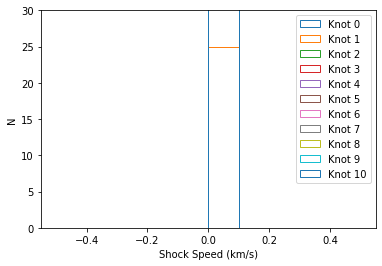

In [6]:
# #paths to data
#applying this to the second epoch...!
path = '../ratios_for_shocks/mappings_shock_speed.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
im_names_shock = sorted(im_name_finder(path, 'fit')) #im_finder is basically glob.glob
im_names_shock = [i.replace('\\', '/') for i in im_names_shock]
print(im_names_shock)

hdu_list = [fits.open(i) for i in im_names_shock]

#initializing some lists to be used
shock_data_list = []
shock_header_list = []

count = 0
for hdu_data in hdu_list:   
    #reading in data for general use  and header for wcs
    shock_data_list.append(hdu_data[0].data) # * hdu_list[0].header['PHOTFLAM'] * hdu_list[0].header['PHOTBW'])
    shock_header_list.append(hdu_data[0].header)
    
    count+=1

#setting up to ignore 0 values, one of the following steps seems to break the histograms
# shock_data_list[0][shock_data_list[0] >= 60] = np.nan
# shock_data_list[0][shock_data_list[0] <= 28] = np.nan
shock_cutout_list = [i.cutout(shock_data_list[0]) for i in aper_mask_list] #cutting out data
shock_avgspeed_list = [np.nanmedian(i) for i in shock_cutout_list]

#histograms to check out the shock speeds
for i in range(len(shock_cutout_list)):
#     if i != 8:
    shock_speed_flat = shock_cutout_list[i].flatten()
    plt.hist(shock_speed_flat, label='Knot '+str(i), histtype='step')
# plt.xlim(20, 100)
plt.xlabel('Shock Speed (km/s)')
plt.ylim(0, 30)
plt.ylabel('N')
plt.legend(loc='best')

In [7]:
shock_avgspeed_list

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [8]:
#have to measure this one by hand...
# shock_avgspeed_list[1] = np.mean([39, 70]) #excluding a measurement of 130, which is a likely outlier
# np.mean([29.74798743100186, 29.74798743100186, 31.406197094893997, 38.039035750462546, 38.039035750462546,
#         39.69724541435468, ])

# shock_avgspeed_list = [29.602, np.mean([27,29,29.5,30,31.25,31.5]), 43.6, 36.9, 35.6053, \
#         28.8271, 27.6754, 30.0574, 33.8886, 45., np.mean([32.5, 37.5, 43, 46.5, 56])]


#main method is look at apertures and individual histograms of each aperture to see which pixels actually matter 
#within the region
shock_avgspeed_list = np.array([51.62423015183755, \
 50.19106600766818, \
 46.94501870077839, \
 50.948835518487996, \
 49.052335863117186, \
 52.292500213274984, \
 52.56264891558462, \
 47.77942447274933, \
 49.31377439546969, \
 49.773454304513365, \
 48.52457446394419])

print(shock_avgspeed_list)

[51.62423015 50.19106601 46.9450187  50.94883552 49.05233586 52.29250021
 52.56264892 47.77942447 49.3137744  49.7734543  48.52457446]


# Looping through regions for tables

In [9]:
# table including knot coords, ellipses sizes, Av values…, include uncertainties! 
#see https://scikit-image.org/docs/stable/auto_examples/registration/plot_masked_register_translation.html

#setting up a pandas table to be saved as excel (will store fluxes for the fitting code)
#pandas used because easy to sort and save
column_names = ['Epoch 1 RA, Dec', 'Epoch 2 RA, Dec', 'Ellipse Semi-Major Axis', 'Ellipse Semi-Minor Axis', '\Av'] #columns
#creating dataframe and filling in the first two columns from the lists we just made
df_cc_knots = pd.DataFrame(columns = column_names)
df_cc_knots['Epoch 1 RA, Dec'] = [str(i[0]) + ', ' + str(j[0]) for i, j in zip(ra_hms_list, dec_dms_list)]
df_cc_knots['Epoch 2 RA, Dec'] = [str(i[1]) + ', ' + str(j[1]) for i, j in zip(ra_hms_list, dec_dms_list)]
df_cc_knots['Ellipse Semi-Major Axis'] = [round(i[1] * hst_pixsize, 2) for i in rad_a_list]
df_cc_knots['Ellipse Semi-Minor Axis'] = [round(i[1] * hst_pixsize, 2) for i in rad_b_list]

#need Av, need to be done by hand
av_avg_list = [30.2658, 24.0487, 9.60311, 15.9761, 17.1154, 20.325, 30.7061, 31.4283, 20.7581, 7.70811, 1.91259]
avuncert_avg_list = [1.62917, 1.48497, 3.84992, 0.731258, 0.672574, 0.967529, 1.80339, 1.12745, 2.03989, 8.7811, 8.74607]
df_cc_knots['\Av'] = [str(round(i,1)) + ' $\pm$ ' + str(round(j,2)) for i,j in zip(av_avg_list, avuncert_avg_list)]

#saving as excel file for use in future codes, make sure to update savepaths
# !conda install --yes --prefix {sys.prefix} openpyxl #may need...IF FIRST TIME DOING THIS/don't have package - takes multiple minutes
# savepath = 'proper_motions.xlsx'
# df_cc_speeds = df_cc_speeds.sort_values(by=['Knot Dec (dd:mm:ss)'], ascending=True)
print(df_cc_knots)
savepath = 'knot_coordinates.tex'
df_cc_knots.to_latex(savepath, index=False)
print('saved speeds!')

                 Epoch 1 RA, Dec               Epoch 2 RA, Dec  \
0   5h47m04.7278s, +0d21m54.424s  5h47m04.7749s, +0d21m56.281s   
1   5h47m04.9808s, +0d22m05.917s  5h47m04.9869s, +0d22m07.256s   
2   5h47m04.9050s, +0d22m15.608s  5h47m04.9488s, +0d22m17.079s   
3   5h47m05.2484s, +0d22m27.308s  5h47m05.2577s, +0d22m28.261s   
4   5h47m05.3264s, +0d22m28.448s  5h47m05.3562s, +0d22m29.181s   
5   5h47m05.4630s, +0d22m30.251s  5h47m05.4940s, +0d22m30.948s   
6   5h47m05.8456s, +0d22m37.350s  5h47m05.8837s, +0d22m37.836s   
7   5h47m05.9158s, +0d22m39.970s  5h47m05.9315s, +0d22m40.507s   
8   5h47m06.6270s, +0d22m44.653s  5h47m06.6131s, +0d22m45.252s   
9   5h47m08.2013s, +0d22m53.882s  5h47m08.2241s, +0d22m53.988s   
10  5h47m08.4797s, +0d22m54.173s  5h47m08.4879s, +0d22m54.500s   

    Ellipse Semi-Major Axis  Ellipse Semi-Minor Axis              \Av  
0                      1.98                     0.75  30.3 $\pm$ 1.63  
1                      0.22                     0.32  24.0 $\pm

C:\Users\arubi\AppData\Local\Temp\ipykernel_22816\1349127378.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_cc_knots.to_latex(savepath, index=False)


In [10]:
# table of speeds (offsets, proper motions, position angles, shock speed, total speed), include uncertainties! 
#see https://scikit-image.org/docs/stable/auto_examples/registration/plot_masked_register_translation.html

import numpy as np

#setting up a pandas table to be saved as excel (will store fluxes for the fitting code)
#pandas used because easy to sort and save
column_names = ['RA Offset', 'Dec Offset', 'Proper Motion', 'Tangential Speed', 'Position Angle', \
                    'Shock Speed', 'Jet Flow Speed'] #columns
#creating dataframe and filling in the first two columns from the lists we just made
df_cc_speeds = pd.DataFrame(columns = column_names)
# df_cc_speeds['Knot Shift in X (pix)'] = [(i[0].ra.value-i[1].ra.value)*3600./hst_pixsize for i in pos_list]
# df_cc_speeds['Knot Shift in Y (pix)'] = [(i[0].dec.value-i[1].dec.value)*3600./hst_pixsize for i in pos_list]
fixed_pixel_uncert = round(2 * hst_pixsize, 3) #uncertainty if wanted
df_cc_speeds['RA Offset'] = [round(i,3) for i in ra_diff_list]
df_cc_speeds['Dec Offset'] = [round(i,3) for i in dec_diff_list] 

#computing table of speeds...
n2071_dist = 1.05036e16  #430.4 pc to km
pix_size = 0.12825
time = 3.469e8 #11 yrs to secs
horiz_propmot = [i /11. for i in ra_diff_list] #df_cc_speeds['RA Offset'].values] #divided by 11 yrs
vert_propmot = [i /11. for i in dec_diff_list] # df_cc_speeds['Dec Offset'].values] #divided by 11 yrs
df_cc_speeds['Proper Motion'] =  [round(np.sqrt(i**2.+j**2.), 3) for i,j in zip(horiz_propmot,vert_propmot)]

horiz_speed = [i * n2071_dist/206265 / time for i in ra_diff_list] # df_cc_speeds['RA Offset'].values] #convert pix->arcsec->use small angle formula for distance->div by t for speed
vert_speed = [i * n2071_dist/206265 / time for i in dec_diff_list] # df_cc_speeds['Dec Offset'].values] #convert pix->arcsec->use small angle formula for distance->div by t for speed
#     print(horiz_speed, vert_speed)
df_cc_speeds['Tangential Speed'] = [round(np.sqrt(i**2.+j**2.), 1) for i,j in zip(horiz_speed,vert_speed)]

#calculating position angles, requires 27 degree correction to rotate it properly wrt WCS north axis
x_pix_offset = [(i[0] - i[1])*hst_pixsize for i in ra_pix_list]
y_pix_offset = [(i[0] - i[1])*hst_pixsize for i in dec_pix_list]
theta_list = [np.arctan(dy/dx)*180/np.pi for dy,dx in \
              zip(y_pix_offset, x_pix_offset)]
              #zip(df_cc_speeds['Dec Offset'], df_cc_speeds['RA Offset'])]
# df_cc_speeds['Position Angle'] = [round(i +90- 26.71875, 1) for i in theta_list] #theta_list
pos_angle_list = []
for i in theta_list: #need to sort through list...relative to 90 degrees as "up"
    if i > 0:
        pos_angle_list.append(round(90-i, 1))
    elif i < 0:
        pos_angle_list.append(round(90+i, 1))
df_cc_speeds['Position Angle'] = pos_angle_list

#recording shock speed and total speed
df_cc_speeds['Shock Speed'] = [round(i, 1) for i in shock_avgspeed_list]
df_cc_speeds['Jet Flow Speed'] = [round(i+j, 1) for i,j \
                                  in zip(df_cc_speeds['Shock Speed'],df_cc_speeds['Tangential Speed'])]

#saving as excel file for use in future codes, make sure to update savepaths
# !conda install --yes --prefix {sys.prefix} openpyxl #may need...IF FIRST TIME DOING THIS/don't have package - takes multiple minutes
# savepath = 'proper_motions.xlsx'
# df_cc_speeds = df_cc_speeds.sort_values(by=['Knot Dec (dd:mm:ss)'], ascending=True)
print(df_cc_speeds)
savepath = 'proper_motions_table.tex'
df_cc_speeds.to_latex(savepath, index=False)
print('saved speeds!')

    RA Offset  Dec Offset  Proper Motion  Tangential Speed  Position Angle  \
0       0.689       1.857          0.180             290.7            20.8   
1       0.078       1.339          0.122             196.9             3.9   
2       0.643       1.471          0.146             235.6            24.1   
3       0.130       0.953          0.087             141.2             8.3   
4       0.440       0.733          0.078             125.5            31.4   
5       0.458       0.697          0.076             122.4            33.7   
6       0.567       0.486          0.068             109.6            49.6   
7       0.230       0.537          0.053              85.8            23.7   
8      -0.214       0.599          0.058              93.4            19.2   
9       0.341       0.106          0.032              52.4            72.8   
10      0.120       0.327          0.032              51.1            20.6   

    Shock Speed  Jet Flow Speed  
0          51.6           342

C:\Users\arubi\AppData\Local\Temp\ipykernel_22816\4155518880.py:57: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_cc_speeds.to_latex(savepath, index=False)


In [11]:
# df_cc_speeds['Shock Speed'].values
# df_cc_speeds['Tangential Speed'].values
# df_cc_speeds['Jet Flow Speed'].values
df_cc_speeds['Position Angle'].values

array([20.8,  3.9, 24.1,  8.3, 31.4, 33.7, 49.6, 23.7, 19.2, 72.8, 20.6])

# Proper motions and Arrow image!

In [12]:
#functions to calculate angles between lines...used for finding angles between arrows
#Credits: taken from https://stackoverflow.com/questions/25227100/best-way-to-plot-an-angle-between-two-lines-in-matplotlib

import math
from matplotlib.patches import Arc

def get_angle_plot(line1, line2, offset = 1, color = None, origin = [0,0], len_x_axis = 1, len_y_axis = 1):

    l1xy = line1.get_xydata()
    l2xy = line2.get_xydata()

    # Angle between line1 and x-axis
    slope1 = -(l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
    angle1 = abs(math.degrees(math.atan(slope1))) # Taking only the positive angle

    # Angle between line2 and x-axis
    slope2 = -(l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
    angle2 = abs(math.degrees(math.atan(slope2)))

    theta1 = min(angle1, angle2)
    theta2 = max(angle1, angle2)

    angle = theta2 - theta1

    if color is None:
        color = line1.get_color() # Uses the color of line 1 if color parameter is not passed.

    return Arc(origin, len_x_axis*offset, len_y_axis*offset, 0, theta1, theta2, color=color, label = str(angle)+u"\u00b0")

def get_angle_text(angle_plot):
    angle = angle_plot.get_label()[:-1] # Excluding the degree symbol
    angle = "%0.2f"%float(angle)+u"\u00b0" # Display angle upto 2 decimal places

    # Get the vertices of the angle arc
    vertices = angle_plot.get_verts()

    # Get the midpoint of the arc extremes
    x_width = (vertices[0][0] + vertices[-1][0]) / 2.0
    y_width = (vertices[0][-1] + vertices[-1][-1]) / 2.0

    #print x_width, y_width

    separation_radius = max(x_width/2.0, y_width/2.0)

    return [ x_width + separation_radius, y_width + separation_radius, angle]  



In [13]:
#overlaying on the difference image
diff_path = '../scaling_for_motions/f160_diff_epoch2_1_nosolver.fits' # #using ** will grab all files even in subdirectories WARNING takes longer
diff_hdu_list = fits.open(diff_path)
diff_data = diff_hdu_list[0].data
diff_header = diff_hdu_list[0].header

stretch_data = np.sinh((diff_data)*2.25) / np.sinh(1./2.25)

2
10


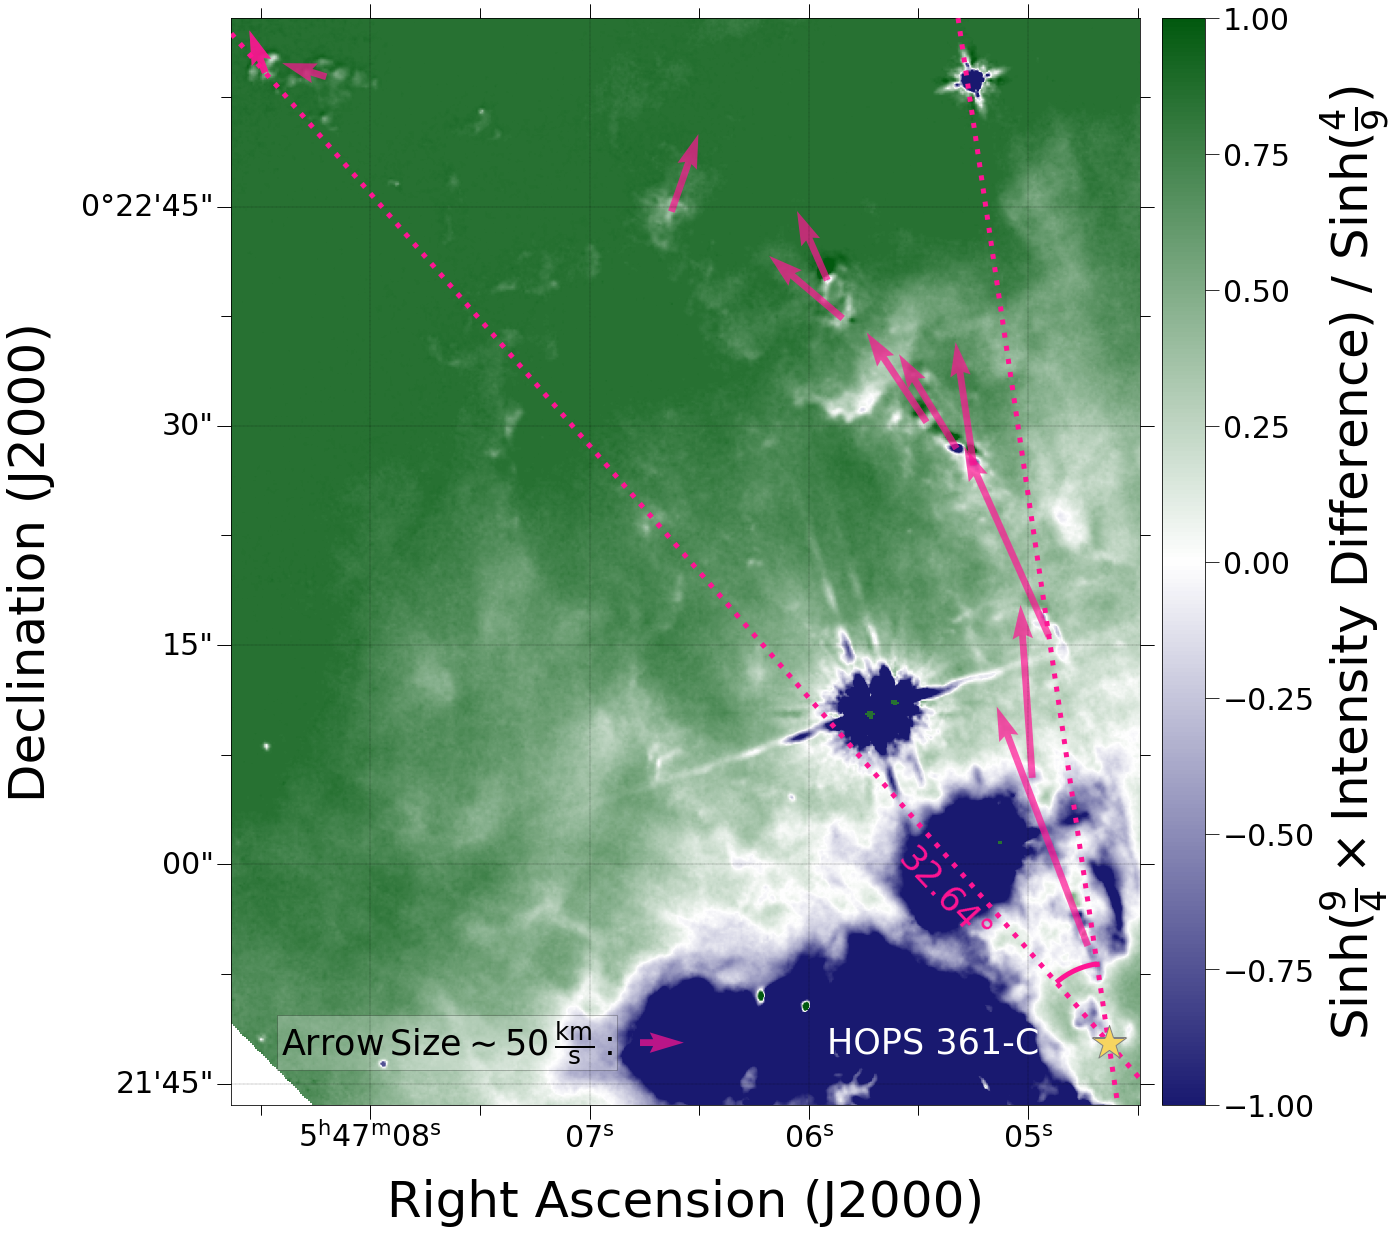

In [14]:
#plotting resulting image
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import SinhStretch, AsinhStretch, LogStretch
from astropy.visualization.wcsaxes import WCSAxesSubplot
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
from matplotlib.colors import TwoSlopeNorm
import matplotlib.ticker
from matplotlib.ticker import LogFormatter, LogLocator, FixedLocator, FixedFormatter
                
#formatting for ticks
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#coordinates for IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s','5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]
coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(diff_header)))
    
#begin plot
fig, ax = plt.subplots(figsize=(30, 20))
#projecting to correctly present data...
wcs = WCS(diff_header)
ax = plt.subplot(projection=wcs) #projecting here

#plotting
interval = ZScaleInterval()
data_interval = interval.get_limits(diff_data)
ds9_min = -1 #-8e-05
ds9_max = 1 # 2e-05
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1]) #automated
norm = ImageNormalize(stretch=AsinhStretch(), vmin=ds9_min, vmax=ds9_max) #from ds9

#plotting arrows and sources
import matplotlib.colors #to setup a new color map that is friendly to colorblindness, can also see https://www.color-blindness.com/coblis-color-blindness-simulator/
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['midnightblue', 'xkcd:white', 'xkcd:deep green']) #similar to cmap='seismic')
# im = ax.imshow(diff_data , norm=norm, origin='lower', cmap=cmap)#'seismic')
im = ax.imshow(stretch_data , norm=TwoSlopeNorm(0, vmin=ds9_min, vmax=ds9_max), origin='lower', cmap=cmap)
hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='xkcd:light mustard', marker='*', s=1300, zorder=5, \
                          edgecolor='gray') for c_pair in coord_pix_list[2:3]]
ax.annotate('HOPS 361-C', (coord_pix_list[2:3][0][0]-150, coord_pix_list[2:3][0][1]), \
            verticalalignment='center', fontsize=35, color='white') 

#overplotting boxes and arrows to show how the method worked
from matplotlib import patches
from matplotlib.lines import Line2D
line_list = []
for ind in range(len(ra_pix_list)):
    #region params
    x_pix = ra_pix_list[ind]
    y_pix = dec_pix_list[ind]

    #arrow params
    x_origin = x_pix[0]#+width_pix/2. #-self_brightest_list[ind][1]
    y_origin = y_pix[0] #+height_pix/2. #-self_brightest_list[ind][0]
    dx = df_cc_speeds['RA Offset'].values[ind]
    dy = df_cc_speeds['Dec Offset'].values[ind]
    if theta_list[ind] < 0:
        theta_calc = theta_list[ind]*np.pi/180 
    else:
        theta_calc = (180+theta_list[ind])*np.pi/180

    #plotting arrows
    ax.quiver(x_origin, y_origin, -np.sqrt(dx**2.+dy**2.)*np.cos(theta_calc), -np.sqrt(dx**2.+dy**2.)*np.sin(theta_calc), \
             color='deeppink', scale_units='xy', angles='xy', units='xy', scale=0.0145, \
             alpha = 0.7)#, facecolor='hotpink', edgecolor='fuchsia')
    #violet or gray may also be possible colors

    #labeling opening angle and lines marking the cone of precession
    if ind == 2 or ind == len(ra_pix_list)-1:
        print(ind)
        line = Line2D([coord_pix_list[2][0], x_origin], [coord_pix_list[2][1], y_origin], color='deeppink')
        m = (coord_pix_list[2][1] - y_origin) / (coord_pix_list[2][0] - x_origin)
        ax.axline(xy1=(coord_pix_list[2]), slope=m, color='deeppink', linestyle=':', lw=5)
        line_list.append(line)

# Gets the arguments to be passed to ax.text as a list to display the angle value besides the arc
#adding angles, had to do calculation myself here because the function is confusing
#...one day should just use get_angle_plot() function, but it isn't working now
from matplotlib.patches import Arc
l1xy = line_list[0].get_xydata()
l2xy = line_list[1].get_xydata()

# Angle between line1 and x-axis
slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
angle1 = (math.degrees(math.atan(slope1))) # Taking only the positive angle
# Angle between line2 and x-axis
slope2 = (l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
angle2 = (math.degrees(math.atan(slope2)))

theta1 = min(angle1, angle2)
theta2 = max(angle1, angle2)

offset=2
ax.add_patch(Arc((coord_pix_list[2][0], coord_pix_list[2][1]), -85, -85, angle=0, theta1=theta1, theta2=theta2, \
             color='deeppink', lw=5))
angle_plot = get_angle_plot(line_list[0], line_list[1], offset=1, color='deeppink', origin=(418, 348)) #increasing x pushes it right, increasing y pushes it up
angle_text = get_angle_text(angle_plot) 
ax.add_patch(angle_plot) # To display the angle arc
ax.text(*angle_text, fontsize=35, color='deeppink', rotation=-47) # To display the angle value


# #adding a compass
# theta_wcs = (135+180)*np.pi/180 #maybe change?
# x, y, arrow_length = 0.873, 0.775, 0.1 #definitely change
# compass_N = ax.annotate('N', xy=(x, y), xytext=(x-arrow_length*np.sin(theta_wcs+np.pi/3.), y+arrow_length*np.cos(theta_wcs+np.pi/3.)), 
#             arrowprops=dict(arrowstyle='<-', lw=4, facecolor='black'),
#             ha='center', va='center', fontsize=40, rotation=25,
#             xycoords='subfigure fraction') #ax.transAxes)
# compass_E = ax.annotate('E', xy=(x, y), xytext=(x-arrow_length/2*np.cos(theta_wcs+np.pi/2.), y-arrow_length/2*np.sin(theta_wcs+np.pi/2.)), 
#             arrowprops=dict(arrowstyle='<-', lw=4, facecolor='black'),
#             ha='center', va='center', fontsize=40, rotation=25,
#             xycoords='subfigure fraction') #ax.transAxes)

#angular scale bar
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
# AnchoredSizeBar(ax.transData, 100, '5 pixels = ' + str(5/hst_pixsize) + ' arcsecs = ' + str(5/hst_pixsize * 430.4/206265), \
#                (86.7699375, 0.36190278), label_top=True, color='fuchsia')
# ax.plot([500,500+1/hst_pixsize * 5], [550, 550], color='black', label='Angular Scale:10 pixels = ~1.3 arcsec')

#legends, needs to be done before angles or else...BAD! THINGS!
ax.coords.grid(True, color='black', ls='--', linewidth=0.25) #adding gridlines, needs to be done before making the arrow
Q = ax.quiver(x_origin, y_origin, -np.sqrt(dx**2.+dy**2.)*np.cos(theta_calc), -np.sqrt(dx**2.+dy**2.)*np.sin(theta_calc), \
         color='deeppink', scale_units='xy', angles='xy', units='xy', scale=0.0145, \
             alpha = 0.7)#, facecolor='hotpink', edgecolor='fuchsia')
axes_speed = np.sum([np.sqrt(dx**2.+dy**2.)*np.cos(theta_calc), np.sqrt(dx**2.+dy**2.)*np.sin(theta_calc)])
# diff_data.shape[0], diff_data.shape[1]
qk = ax.quiverkey(Q, coord_pix_list[2:3][0][0]-250, coord_pix_list[2:3][0][1], axes_speed/0.6, \
                  label=r'$\rm Arrow \, Size \sim 50 \, \frac{km}{s}:$', labelcolor='black', \
                  labelpos='W', labelsep=0.375, coordinates='data', angle=180, fontproperties={'size':35}, alpha=0.7)
t = qk.text.set_bbox(dict(facecolor='white', alpha=0.25))
# ax.quiver(0, 0, -2, 0, color='fuchsia', label='Arrow Scale: 44 km/s', scale_units='xy', angles='xy', units='xy')
# ax.scatter(0, 0, color='fuchsia', marker='*', s=500, label='HOPS 361-C')
# ax.legend(loc='lower left', fontsize=40)

#general formatting
ax.set_xlim(275, 760) #zoom in, is formatted like (left side of map, right side of map)
ax.set_ylim(470, 1050) #is formatted like (bottom of map, top of map)
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=50) #labels
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=50)   
ax.coords[0].set_minor_frequency(2) #for minor ticks
ax.coords[1].set_minor_frequency(2)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False) 
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', which='minor', length=10)
ax.tick_params(axis='y', which='minor', length=10)
# ax.invert_yaxis() #done because it's nicer with declination increasing going up
# ax.invert_xaxis()

#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 

#color bar label and tick labels
# sub_labels = [2]
# cbar.locator = LogLocator(base=10, subs=sub_labels)
cbar.ax.tick_params(labelsize=30)
cbar.update_ticks()
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm Sinh(\frac{9}{4} \times Intensity \ Difference) ~/~ Sinh(\frac{4}{9})$', size=50)
# cbar_tickfont = [cbar.ax.set_yticklabels(labels=cbar.ax.get_yticklabels())[i].set_fontweight('normal') for i in range(len(cbar.ax.get_yticklabels()))]


#saving
plt.savefig('f160w_diff_epoch21_arrowsbyhand_rotated.png', dpi=300, bbox_inches="tight")
plt.savefig('f160w_diff_epoch21_arrowsbyhand_rotated.pdf', dpi=300, bbox_inches="tight")

In [ ]:
#trying to do math to double check the compass arrow and our WCS orientation
# x-arrow_length*np.sin(theta_wcs+np.pi/3.), y+arrow_length*np.cos(theta_wcs+np.pi/3.)
# x-arrow_length/2*np.cos(theta_wcs+np.pi/2.), y-arrow_length/2*np.sin(theta_wcs+np.pi/2.)
135+180+60, 135+180+90 #quadrants are second quadrant, third quadrant

#let's say it's 15 deg from up on the image, left on the image...then...
#thus the actual angles of interest are 90+15=105 and 15+180=195

# Some practice calculations with tables, which are improved in other folders

In [ ]:
#the coordinates of HOPS 361C
hops_361c_coord = SkyCoord('5h47m4.631s', '0d21m47.82s', frame=FK5)

hops_361a_coord = SkyCoord('5h47m4.784s', '0d21m42.85s', frame=FK5)
hops_361b_coord = SkyCoord('5h47m4.755s', '0d21m45.45s', frame=FK5)
hops_361d_coord = SkyCoord('5h47m4.317s', '0d21m38.03s', frame=FK5)
hops_361e_coord = SkyCoord('5h47m4.623s', ' 0d21m41.30s', frame=FK5)


knot_source_sep = [hops_361c_coord.separation(i[1]).arcsecond for i in pos_list] #arcsec
knot_source_sep_notc = [hops_361e_coord.separation(i[1]).arcsecond for i in pos_list] #trying out other stars...
knot_source_dist = np.array([i* 430.4/206265 for i in knot_source_sep]) #hardcoded the dist to 2071 in pc

In [ ]:
knot_source_dist

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(10, 10))

#fit is maybe linear, quadratic, hyperbolic, power law?
ax[0].scatter(knot_source_dist, df_cc_speeds['Tangential Speed (km/s)'].values, color='black')
ax[0].set_ylabel('Tangential Knot Speed (km/s)', fontsize=15)
ax[0].get_xaxis().set_visible(False)
ax[0].tick_params(axis='y', labelsize=15)

#fit is maybe linear, quadratic, hyperbolic, power law?
ax[1].scatter(knot_source_dist, shock_avgspeed_list, color='black')
ax[1].set_ylabel('Shock Speed (km/s)', fontsize=15)
ax[1].get_xaxis().set_visible(False)
ax[1].tick_params(axis='y', labelsize=15)

#plotting outflow speed...
outflow_speeds = shock_avgspeed_list+df_cc_speeds['Tangential Speed (km/s)'].values
ax[2].scatter(knot_source_dist, outflow_speeds, color='black')

#fit is exponential decay then because drag?
#https://ufla.br/dcom/wp-content/uploads/2017/01/artigo-publicado-na-revista-Physics-Education.pdf
from scipy.optimize.minpack import curve_fit
guess_a, guess_b, guess_c = 1, 1, 1
guess = [guess_a, guess_b, guess_c]
exp_decay = lambda x, A, t, y0: A * np.exp(x * t) + y0
params, cov = curve_fit(exp_decay, knot_source_dist, outflow_speeds, p0=guess)
A, t, y0 = params

#plotting best fit decay
best_fit = lambda x: A * np.exp(t * x) + y0
dist_interp = np.linspace(np.min(knot_source_dist), np.max(knot_source_dist), 500)
ax[2].plot(dist_interp, best_fit(dist_interp), 'k-')

#formatting
ax[2].set_ylabel('Outflow Speed (km/s)', fontsize=15)
ax[2].set_xlabel('Knot-Protostar Separation (pc)', fontsize=15)
ax[2].tick_params(axis='x', labelsize=15)
ax[2].tick_params(axis='y', labelsize=15)

plt.savefig('speed_dist_trends.png', dpi=300, bbox_inches="tight")

In [ ]:
#errorbars are from 2 pixels...need to try to reduce it down to 1 pixel or sub-pixel
#1 pixel is about 22 km/s and about 0.001 pc
plt.errorbar(knot_source_dist, shock_avgspeed_list, xerr=0.001, color='black', marker='x', label='Shocked Gas', linestyle='')
plt.errorbar(knot_source_dist, df_cc_speeds['Tangential Speed (km/s)'].values, xerr=0.001, yerr=22, color='goldenrod', marker='^', label='Tangential (Proper) Motion', linestyle='')
plt.errorbar(knot_source_dist, outflow_speeds, yerr=22, xerr=0.001, color='forestgreen', marker='o', label='Bulk Outflow', linestyle='')

#plotting best fit decay (testing linear here, but it turns out worse)
# guess_a, guess_b = 1, 1
# guess_linear = [guess_a, guess_b]
# linear = lambda x, m, b: m*x + b
# params, cov = curve_fit(linear, knot_source_dist, outflow_speeds, p0=guess_linear)
# m, b = params
# best_fit = lambda x: m*x + b
dist_interp = np.linspace(np.min(knot_source_dist), np.max(knot_source_dist), 500)
plt.plot(dist_interp, best_fit(dist_interp), 'k-')

#formatting
plt.legend(loc='best')
plt.ylabel('Speed (km/s)', fontsize=15)
plt.xlabel('Distance from HOPS 361C (pc)', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.ylim(0, 450)

In [ ]:
# shock_avgspeed_list

df_cc_speeds['Tangential Speed (km/s)'].values

# account for angle

**next = Take dot product between displacement vector and velocity vector so that we have one reference point for 
the ballistically expected motion and one reference point for the the actual knot motion**

In [ ]:
theta_list = [np.arctan(dy/dx)*180/np.pi +90- 26.71875 for dy,dx in zip(y_pix_offset, x_pix_offset)]
print(theta_list)

knot_source_pa = [hops_361c_coord.position_angle(i[1]).degree for i in pos_list]
print(knot_source_pa )

In [ ]:
#actual proper motion angles
plt.scatter(knot_source_dist, theta_list, color='goldenrod', label='Tangential Motion')
# plt.scatter(knot_source_dist[0:2], theta_list[0:2], color='goldenrod', label='Tangential Motion')
# plt.scatter(np.mean(knot_source_dist[3:5]), np.mean(theta_list[3:5]), color='goldenrod')
# plt.scatter(np.mean(knot_source_dist[5:7]), np.mean(theta_list[5:7]), color='goldenrod')
# plt.scatter(knot_source_dist[7], theta_list[7], color='goldenrod')
# plt.scatter(np.mean(knot_source_dist[8:11]), np.mean(theta_list[8:11]), color='goldenrod')

#angle from protostar to knot, if ballistic
plt.plot(knot_source_dist, knot_source_pa, color = 'green', marker='o', label='Ballistic Assumption')

#trying to figure out the difference...likely due to inclination?
plt.scatter(knot_source_dist, theta_list-knot_source_pa, color='black')
# plt.scatter(knot_source_dist[0:2], theta_list[0:2]-knot_source_pa[0:2], color='black')
# plt.scatter(np.mean(knot_source_dist[3:5]), np.mean(theta_list[3:5]-knot_source_pa[3:5]), color='black')
# plt.scatter(np.mean(knot_source_dist[5:7]), np.mean(theta_list[5:7]-knot_source_pa[5:7]), color='black')
# plt.scatter(knot_source_dist[7], theta_list[7], color='black')
# plt.scatter(np.mean(knot_source_dist[8:11]), np.mean(theta_list[8:11]-knot_source_pa[8:11]), color='black')
plt.plot(knot_source_dist, [np.mean(theta_list-knot_source_pa)] * len(knot_source_dist), color='black', linestyle='--', label='Difference')
print(np.mean(theta_list-knot_source_pa))

#formatting
plt.legend(loc='best')
plt.ylabel('Position Angle (Degrees)', fontsize=15)
plt.xlabel('Distance from HOPS 361C (pc)', fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

In [ ]:
# theta_uncert_list = []
# for ind in range(len(ra_pix_list)):
#     #finding angle
#     dx = df_cc_speeds['RA Offset'].va[ind]
#     dy = df_cc_speeds['Dec Offset'].values[ind]
#     theta_offset_calc = np.arctan((dy+1)/(dx)) * 180/np.pi + 90- 26.71875 #calculating with an offset of 1 pixel
#     theta_uncert_list.append(theta_offset_calc - theta_list[ind])
# print(theta_uncert_list)

print([np.abs(np.arctan((dy+1)/(dx-1))*180/np.pi +90- 26.71875) for dy,dx in zip(y_pix_offset, x_pix_offset)])


In [ ]:
#calculating a confidence interval
#based on https://stackoverflow.com/questions/39434402/how-to-get-confidence-intervals-from-curve-fit

# y_means = np.array(outflow_speeds).mean(axis = 1) # averages and dispersion of data
y_spread = [22]*len(outflow_speeds) #np.array(outflow_speeds).std(axis = 1)

from scipy.optimize.minpack import curve_fit
guess_a, guess_b, guess_c = 1, 1, 1
guess = [guess_a, guess_b, guess_c]
exp_decay = lambda x, A, t, y0: A * np.exp(x * t) + y0
params, cov = curve_fit(exp_decay, knot_source_dist, outflow_speeds, p0=guess, sigma=y_spread, absolute_sigma=True)
sigma_p = np.sqrt(np.diagonal(cov))
print(sigma_p)
A, t, y0 = params

#plotting best fit decay
best_fit = lambda x: A * np.exp(t * x) + y0
dist_interp = np.linspace(np.min(knot_source_dist), np.max(knot_source_dist), 500)

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10, 10))

#plotting speed data
ax[0].errorbar(knot_source_dist, shock_avgspeed_list, color='black', marker='x', label='Shocked Gas', linestyle='', linewidth=0.8)
ax[0].errorbar(knot_source_dist, df_cc_speeds['Tangential Speed (km/s)'].values, yerr=22, color='goldenrod', marker='^', label='Tangential (Proper) Motion', linestyle='', linewidth=0.8)
ax[0].errorbar(knot_source_dist, outflow_speeds, yerr=22, color='forestgreen', marker='o', label='Bulk Outflow and Jet', linestyle='', linewidth=0.8)

# plotting the confidence intervals and fit
ax[0].plot(dist_interp, best_fit(dist_interp), 'k-', label='Exponential Trend') #fit
# bound_upper = exp_decay(dist_interp, *(params + sigma_p))
# bound_lower = exp_decay(dist_interp, *(params - sigma_p))
# ax[0].fill_between(dist_interp, bound_lower, bound_upper, color = 'black', alpha = 0.15)

ax[0].set_ylim(0, 450) #formatting
ax[0].set_ylabel('Speed (km/s)', fontsize=15)
ax[0].get_xaxis().set_visible(False)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].legend(loc='best', fontsize=15)

#plotting angular, unsure on fit
# ax[1].scatter(knot_source_dist, theta_list, color='goldenrod')
# ax[1].errorbar(knot_source_dist[0:2], theta_list[0:2], color='goldenrod', yerr=theta_uncert_list[0:2], linestyle='', linewidth=0.8, marker='o')
# ax[1].errorbar(np.mean(knot_source_dist[3:5]), np.mean(theta_list[3:5]), color='goldenrod', yerr=np.mean(theta_uncert_list[3:5]), linestyle='', linewidth=0.8, marker='o')
# ax[1].errorbar(np.mean(knot_source_dist[5:7]), np.mean(theta_list[5:7]), color='goldenrod', yerr=np.mean(theta_uncert_list[5:7]), linestyle='', linewidth=0.8, marker='o')
# ax[1].errorbar(knot_source_dist[7], np.mean(theta_list[7]), color='goldenrod', yerr=theta_uncert_list[7], linestyle='', linewidth=0.8, marker='o')
# ax[1].errorbar(np.mean(knot_source_dist[8:11]), np.mean(theta_list[8:11]), color='goldenrod', yerr=np.mean(theta_uncert_list[8:11]), linestyle='', linewidth=0.8, marker='o')

# ax[1].scatter(knot_source_dist, theta_list-knot_source_pa, color='black')
ax[1].plot(knot_source_dist, [np.mean(theta_list-knot_source_pa)] * len(knot_source_dist), color='black', linestyle='--', label='Mean Difference')
ax[1].plot(knot_source_dist, knot_source_pa, color = 'blue', marker='s', label='Ballistic Assumption')
ax[1].errorbar(knot_source_dist, theta_list, yerr=np.abs(theta_uncert_list), color='goldenrod', label='Tangential Motion', linestyle='', marker='^')

ax[1].set_ylabel('Position Angle (Degrees)', fontsize=15)
ax[1].tick_params(axis='y', labelsize=15)

#formatting x-axis
ax[1].set_xlabel('Knot-Protostar Separation (pc)', fontsize=15)
ax[1].tick_params(axis='x', labelsize=15)
plt.subplots_adjust(hspace=0.05)
ax[1].legend(loc='best', fontsize=15)

plt.savefig('speed_dist_trends.png', dpi=300, bbox_inches="tight")
plt.savefig('speed_dist_trends.pdf', dpi=300, bbox_inches="tight")

# Making an Appendix of Knots

In [15]:
#options are cutout2D from astropy or photutils apertures (my preference)
# https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord, FK5, ICRS
from photutils.aperture import RectangularAperture

#known pixel size
hst_pixsize = 0.12825 #arcsec

#reading in the .reg files made using DS9 
f1 = open('361cjet_f160w_knots.reg', 'r')
file1_output = []
file2_output = []

#looping through files
for line in f1:
    file1_output.append(line)
f1.close()

#fix file contents
#contents are ra, dec, width, height, rotation
file1_output = [i[4:-2] for i in file1_output[3:]]

#next step is for image, loop through all regions and make a list of region properties
sq_ra_diff_list = []
sq_dec_diff_list = []
sq_ra_pix_list = []
sq_dec_pix_list = []
side_a_list = []
side_b_list = []
sq_rotation_list = []

#coordinate details very much compacted (likely better ways to do this)
split_params1 = [i.split(',') for i in file1_output]
sq_ra_hms_list = [(ra1[0].split(':')[0]+'h' + ra1[0].split(':')[1]+'m' + ra1[0].split(':')[2]+'s') for ra1 in split_params1]
sq_dec_dms_list = [(dec1[1].split(':')[0]+'d' + dec1[1].split(':')[1]+'m' + dec1[1].split(':')[2]+'s') for dec1 in split_params1]

#offsets that can be used for finding knot offsets between epochs
sq_pos_list = [SkyCoord(ra+' '+dec, frame=FK5, unit=(u.hourangle, u.deg)) for ra, dec in zip(sq_ra_hms_list, sq_dec_dms_list)] #this is all in degrees, what a lie...units are input units

#this isn't working for some reason...skycoord_to_pixel doesn't seem to like the units? not sure
sq_ra_pix_list = [skycoord_to_pixel(i, wcs=WCS(hdu_header_list[0]))[0] for i in sq_pos_list]
sq_dec_pix_list = [skycoord_to_pixel(i, wcs=WCS(hdu_header_list[0]))[1] for i in sq_pos_list]

#aperture size details in pixels (?)
side_a_list = [1./hst_pixsize * float(sq_a1[2][:-1]) for sq_a1 in split_params1]
side_b_list = [1./hst_pixsize * float(sq_b1[3][:-1]) for sq_b1 in split_params1]
sq_rotation_list = [float(rot1[4]) for rot1 in split_params1]

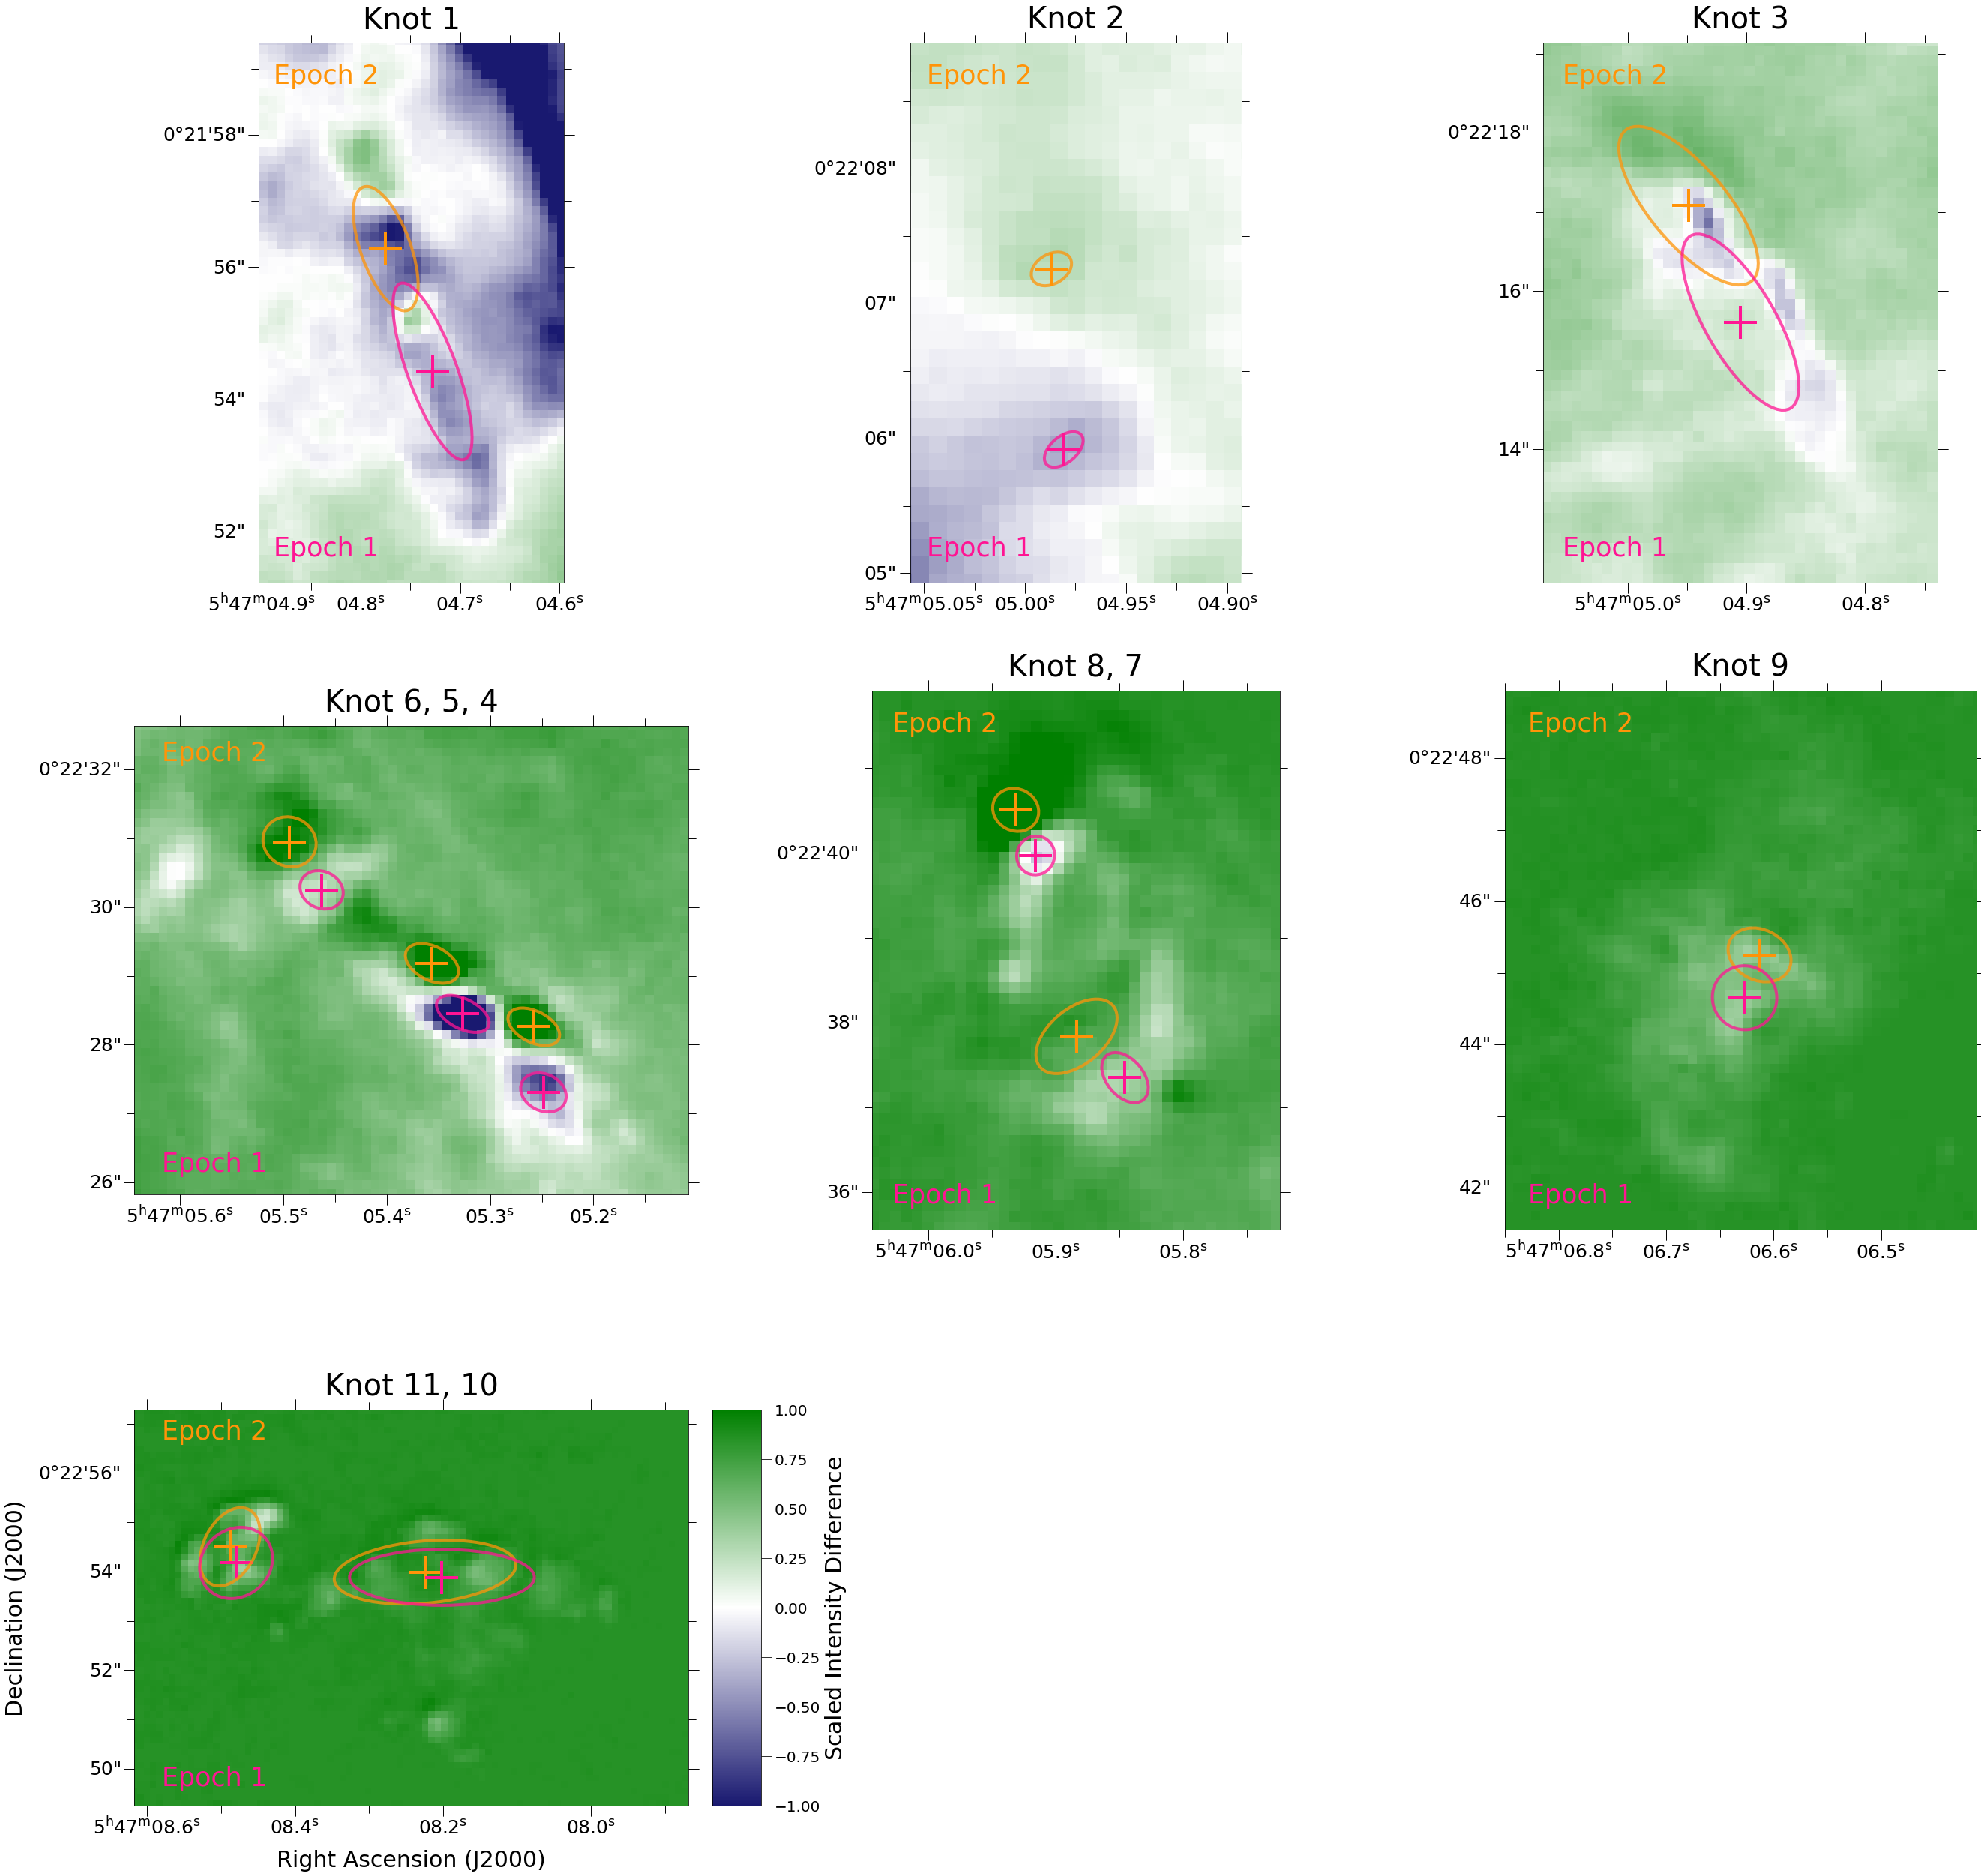

In [65]:
   
#formatting for ticks
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#plotting arrows and sources
import matplotlib.colors #to setup a new color map that is friendly to colorblindness, can also see https://www.color-blindness.com/coblis-color-blindness-simulator/
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["midnightblue","white","green"]) #similar to cmap='seismic')

#setup plot, we have 7 boxes, so we'll want 3 rows and 4 cols ro 4 rows and 3 cols
fig = plt.figure(figsize=(45, 45))
N = len(sq_ra_hms_list)
cols = 3
rows = int(math.ceil(N / cols))
from matplotlib import gridspec
gs = gridspec.GridSpec(rows, cols)

#ellipse properties
ellipse_lw = 4 #before it was 3

wcs = WCS(diff_header) #projecting to correctly present data...
from matplotlib.patches import Ellipse
for ind in range(len(sq_ra_hms_list)):
    #replacing a figure subplot
    ax = fig.add_subplot(gs[ind], projection=wcs)
    
    #plot
    ds9_min = -1 #-8e-05
    ds9_max = 1 # 2e-05
    im = ax.imshow(stretch_data , norm=TwoSlopeNorm(0, vmin=ds9_min, vmax=ds9_max), origin='lower', cmap=cmap)

    #region params for areas of interest
    ax.set_xlim(sq_ra_pix_list[ind] - side_a_list[ind]/2, sq_ra_pix_list[ind] + side_a_list[ind]/2) #zoom in, is formatted like (left side of map, right side of map)
    ax.set_ylim(sq_dec_pix_list[ind] - side_b_list[ind]/2, sq_dec_pix_list[ind] + side_b_list[ind]/2) #is formatted like (bottom of map, top of map)

    #using cropped region to set epochs
    ax.annotate('Epoch 1', (0.05, 0.05), fontsize=35, color='deeppink', xycoords='axes fraction')
    ax.annotate('Epoch 2', (0.05, 0.925), fontsize=35, color='xkcd:tangerine', xycoords='axes fraction')

    #labeling features on the regions
    ptsize = 2000
    if ind+1 <= 3: #just grab first one you get
        x_pix = ra_pix_list[ind]
        y_pix = dec_pix_list[ind]
    #     x_origin = x_pix[0]#+width_pix/2. #-self_brightest_list[ind][1]
    #     y_origin = y_pix[0]
        # ax.scatter(x_pix, y_pix, marker='+', s=ptsize, color='deeppink', linewidths=3)
        
        #plot elliptical regions
        ellipse1 = Ellipse((ra_pix_list[ind][1], dec_pix_list[ind][1]), rad_a_list[ind][1], \
                          rad_b_list[ind][1], rotation_list[ind][1], color='xkcd:tangerine', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse1)
        ax.scatter(x_pix[1], y_pix[1], marker='+', s=ptsize, color='xkcd:tangerine', linewidths=ellipse_lw)
        ellipse2 = Ellipse((ra_pix_list[ind][0], dec_pix_list[ind][0]), rad_a_list[ind][0], \
                  rad_b_list[ind][0], rotation_list[ind][0], color='deeppink', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse2)
        ax.scatter(x_pix[0], y_pix[0], marker='+', s=ptsize, color='deeppink', linewidths=4)

        #adding labels for knots and epochs to demonstrate direciton of motion
        ax.set_title('Knot ' + str(ind+1), fontsize=40, pad=20)
        
    elif ind+1 == 4: #grab 3th, 4th, 5th
        x_pix = ra_pix_list[ind] + ra_pix_list[ind+1] + ra_pix_list[ind+2]  
        y_pix = dec_pix_list[ind] + dec_pix_list[ind+1] + dec_pix_list[ind+2]  
        # ax.scatter(x_pix, y_pix, marker='+', s=ptsize, color='deeppink', linewidths=3)
        
        #plot elliptical regions
        ellipse = Ellipse((ra_pix_list[ind][1], dec_pix_list[ind][1]), rad_a_list[ind][1], \
                          rad_b_list[ind][1], rotation_list[ind][1], color='xkcd:tangerine', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[1], y_pix[1], marker='+', s=ptsize, color='xkcd:tangerine', linewidths=ellipse_lw)
        ellipse = Ellipse((ra_pix_list[ind][0], dec_pix_list[ind][0]), rad_a_list[ind][0], \
                  rad_b_list[ind][0], rotation_list[ind][0], color='deeppink', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[0], y_pix[0], marker='+', s=ptsize, color='deeppink', linewidths=ellipse_lw)
        
        ellipse = Ellipse((ra_pix_list[ind+1][1], dec_pix_list[ind+1][1]), rad_a_list[ind+1][1], \
                  rad_b_list[ind+1][1], rotation_list[ind+1][1], color='xkcd:tangerine', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[3], y_pix[3], marker='+', s=ptsize, color='xkcd:tangerine', linewidths=ellipse_lw)
        ellipse = Ellipse((ra_pix_list[ind+1][0], dec_pix_list[ind+1][0]), rad_a_list[ind+1][0], \
                  rad_b_list[ind+1][0], rotation_list[ind+1][0], color='deeppink', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[2], y_pix[2], marker='+', s=ptsize, color='deeppink', linewidths=ellipse_lw)
        
        ellipse = Ellipse((ra_pix_list[ind+2][1], dec_pix_list[ind+2][1]), rad_a_list[ind+2][1], \
                  rad_b_list[ind+2][1], rotation_list[ind+2][1], color='xkcd:tangerine', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[5], y_pix[5], marker='+', s=ptsize, color='xkcd:tangerine', linewidths=ellipse_lw)
        ellipse = Ellipse((ra_pix_list[ind+2][0], dec_pix_list[ind+2][0]), rad_a_list[ind+2][0], \
                  rad_b_list[ind][0], rotation_list[ind+2][0], color='deeppink', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[4], y_pix[4], marker='+', s=ptsize, color='deeppink', linewidths=ellipse_lw)

        #adding labels for knots and epochs to demonstrate direciton of motion
        ax.set_title('Knot ' + str(ind+3) + ', ' + str(ind+2) + ', ' + str(ind+1), fontsize=40, pad=20)
        
    elif ind+1 == 5: #grab 6th, 7th
        x_pix = ra_pix_list[ind+3] + ra_pix_list[ind+2]
        y_pix = dec_pix_list[ind+3] + dec_pix_list[ind+2]
        # ax.scatter(x_pix, y_pix, marker='+', s=ptsize, color='deeppink', linewidths=3) 

        #plot elliptical regions
        ellipse = Ellipse((ra_pix_list[ind+2][1], dec_pix_list[ind+2][1]), rad_a_list[ind+2][1], \
                  rad_b_list[ind+2][1], rotation_list[ind+2][1], color='xkcd:tangerine', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[1], y_pix[1], marker='+', s=ptsize, color='xkcd:tangerine', linewidths=ellipse_lw)
        ellipse = Ellipse((ra_pix_list[ind+2][0], dec_pix_list[ind+2][0]), rad_a_list[ind+2][0], \
                  rad_b_list[ind][0], rotation_list[ind+2][0], color='deeppink', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[0], y_pix[0], marker='+', s=ptsize, color='deeppink', linewidths=ellipse_lw)

        
        ellipse = Ellipse((ra_pix_list[ind+3][1], dec_pix_list[ind+3][1]), rad_a_list[ind+3][1], \
                          rad_b_list[ind][1], rotation_list[ind][1], color='xkcd:tangerine', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[3], y_pix[3], marker='+', s=ptsize, color='xkcd:tangerine', linewidths=ellipse_lw)
        ellipse = Ellipse((ra_pix_list[ind+3][0], dec_pix_list[ind+3][0]), rad_a_list[ind+3][0], \
                  rad_b_list[ind+3][0], rotation_list[ind+3][0], color='deeppink', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[2], y_pix[2], marker='+', s=ptsize, color='deeppink', linewidths=ellipse_lw)

        #adding labels for knots and epochs to demonstrate direciton of motion
        ax.set_title('Knot ' + str(ind+4) + ', ' + str(ind+3), fontsize=40, pad=20)
        
    elif ind+1 == 6: #8th
        x_pix = ra_pix_list[ind+3]
        y_pix = dec_pix_list[ind+3]
        # ax.scatter(x_pix, y_pix, marker='+', s=ptsize, color='deeppink', linewidths=3)  
        
        #plot elliptical regions
        ellipse = Ellipse((ra_pix_list[ind+3][1], dec_pix_list[ind+3][1]), rad_a_list[ind+3][1], \
                          rad_b_list[ind][1], rotation_list[ind][1], color='xkcd:tangerine', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[1], y_pix[1], marker='+', s=ptsize, color='xkcd:tangerine', linewidths=ellipse_lw)
        ellipse = Ellipse((ra_pix_list[ind+3][0], dec_pix_list[ind+3][0]), rad_a_list[ind+3][0], \
                  rad_b_list[ind+3][0], rotation_list[ind+3][0], color='deeppink', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[0], y_pix[0], marker='+', s=ptsize, color='deeppink', linewidths=ellipse_lw)

        #adding labels for knots and epochs to demonstrate direciton of motion
        ax.set_title('Knot ' + str(ind+4), fontsize=40, pad=20)
        
    elif ind+1 == 7: #9th and 10th
        x_pix = ra_pix_list[ind+4] + ra_pix_list[ind+3]
        y_pix = dec_pix_list[ind+4] + dec_pix_list[ind+3]
        # ax.scatter(x_pix, y_pix, marker='+', s=ptsize, color='deeppink', linewidths=3)  
        
        #plot elliptical regions
        ellipse = Ellipse((ra_pix_list[ind+3][1], dec_pix_list[ind+3][1]), rad_a_list[ind+3][1], \
                          rad_b_list[ind+3][1], rotation_list[ind+3][1], color='xkcd:tangerine', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[1], y_pix[1], marker='+', s=ptsize, color='xkcd:tangerine', linewidths=ellipse_lw)
        ellipse = Ellipse((ra_pix_list[ind+3][0], dec_pix_list[ind+3][0]), rad_a_list[ind+3][0], \
                  rad_b_list[ind+3][0], rotation_list[ind+3][0], color='deeppink', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[0], y_pix[0], marker='+', s=ptsize, color='deeppink', linewidths=ellipse_lw)
        
        ellipse = Ellipse((ra_pix_list[ind+4][1], dec_pix_list[ind+4][1]), rad_a_list[ind+4][1], \
                          rad_b_list[ind+4][1], rotation_list[ind+4][1], color='xkcd:tangerine', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[3], y_pix[3], marker='+', s=ptsize, color='xkcd:tangerine', linewidths=ellipse_lw)
        ellipse = Ellipse((ra_pix_list[ind+4][0], dec_pix_list[ind+4][0]), rad_a_list[ind+4][0], \
                  rad_b_list[ind+4][0], rotation_list[ind][0], color='deeppink', fc='None', lw=ellipse_lw, alpha=0.75)
        ax.add_patch(ellipse)
        ax.scatter(x_pix[2], y_pix[2], marker='+', s=ptsize, color='deeppink', linewidths=ellipse_lw)

        #adding labels for knots and epochs to demonstrate direciton of motion
        ax.set_title('Knot ' + str(ind+5) + ', ' + str(ind+4), fontsize=40, pad=20)
        
#     general formatting
    ax.coords[0].set_minor_frequency(2) #for minor ticks
    ax.coords[1].set_minor_frequency(2)
    ax.coords[0].display_minor_ticks(True)
    ax.coords[1].display_minor_ticks(True)
    ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False) 
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    ax.tick_params(axis='x', which='minor', length=10)
    ax.tick_params(axis='y', which='minor', length=10)    
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    
    if ind == N-1:
        ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30) #labels
        ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   

                #colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        cbar = plt.colorbar(im, cax=cax) 

        #color bar label and tick labels
        cbar.ax.tick_params(labelsize=20)
        cbar.update_ticks()
        cbar.ax.yaxis.get_offset_text().set_fontsize(0)
        cbar.set_label(label=r'$\rm Scaled \ Intensity \ Difference$', size=30)

#saving
plt.savefig('appendix_zoom_epoch21_diff.png', dpi=300, bbox_inches="tight")
plt.savefig('appendix_zoom_epoch21_diff.pdf', dpi=300, bbox_inches="tight")